In [1]:
#cant use probability matrix method for more than 1 character of context
#use MLP to predict next token

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [72]:
#build dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] #X = inputs, Y = labels
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.': #padding with '.' to indicate end of word
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    #rolling window of context
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [12]:
#embedding

C = torch.randn((27, 2)) #we can cram into 27-dim space since we have only 27 characters


In [ ]:
#F.one_hot(torch.tensor(5), num_classes = 27).float() @ C
C[5]
#embedding lookup is just a matrix multiplication

tensor([ 0.3279, -1.7527])

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [17]:
W1 = torch.randn((6,100)) # 6 = 3 chars * 2 dim each
b1 = torch.randn(100)

#emb @ W1 + b1 not possible due to shape mismatch
# 32 3 2  x  6 100
#need 32 6 x 6 100
torch.cat(
    [emb[:, 0, :], #first 2d emb of char for each example
    emb[:, 1, :], 
    emb[:, 2, :]],
    dim=1 # concatenate along columns
)
#one column per example with 3 char embeddings concatenated
#this code does not generalize to different block sizes

#torch.unbind removes a tensor dim and returns a tuple of tensor slices

torch.cat(torch.unbind(emb, 1), 1).shape


In [30]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [ ]:
a.view(3, 3, 2) #works as long as total number of elements is same

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [32]:
emb.view(32, 6)

tensor([[-1.7092,  1.0745, -1.7092,  1.0745, -1.7092,  1.0745],
        [-1.7092,  1.0745, -1.7092,  1.0745,  1.7035, -0.6191],
        [-1.7092,  1.0745,  1.7035, -0.6191,  0.7824,  1.3979],
        [ 1.7035, -0.6191,  0.7824,  1.3979,  0.7824,  1.3979],
        [ 0.7824,  1.3979,  0.7824,  1.3979, -1.0540,  1.7888],
        [-1.7092,  1.0745, -1.7092,  1.0745, -1.7092,  1.0745],
        [-1.7092,  1.0745, -1.7092,  1.0745, -1.9464,  0.1017],
        [-1.7092,  1.0745, -1.9464,  0.1017,  0.0718, -0.6997],
        [-1.9464,  0.1017,  0.0718, -0.6997, -0.2716,  1.4650],
        [ 0.0718, -0.6997, -0.2716,  1.4650, -0.3013,  0.3661],
        [-0.2716,  1.4650, -0.3013,  0.3661, -0.2716,  1.4650],
        [-0.3013,  0.3661, -0.2716,  1.4650, -1.0540,  1.7888],
        [-1.7092,  1.0745, -1.7092,  1.0745, -1.7092,  1.0745],
        [-1.7092,  1.0745, -1.7092,  1.0745, -1.0540,  1.7888],
        [-1.7092,  1.0745, -1.0540,  1.7888, -0.3013,  0.3661],
        [-1.0540,  1.7888, -0.3013,  0.3

In [37]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1) #100 dim activation per example
#output layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
#softmax to get probabilities
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [ ]:
#actual layer Y
loss = -probs[torch.arange(len(X)), Y].log().mean()

tensor(17.0942)

In [105]:
#--------------more compactly-----------------
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)
#only 32 samples and 3481 parameters - overfitting likely

3481

In [104]:
#figuring out the ideal learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
 #candidate lrs

In [106]:
lri = []
lossi = []


for i in range(100000):   

    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) #only get 32 rows at a time

    #forward pass
    emb = C[X[ix]] #(32, 3, 2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(len(X)), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) #combines softmax and nll loss in one function
    #print(i, loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward() #make sure p.requires_grad = True for all elems

    #update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.129484176635742


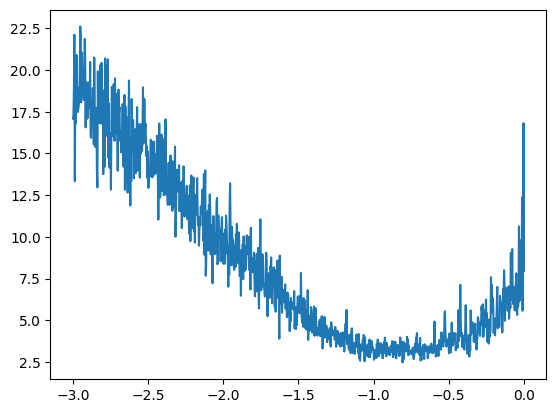

In [100]:
plt.plot(lri,lossi)

In [ ]:
#want to create smaller batches and train on them
torch.randint(0, X.shape[0], (32,))
#better to train on approximate gradient with less steps than actual gradient going through the whole dataset

tensor([197199,  51682,  10501,  79935,  42844, 195788,  77527, 163604, 116008,
        202993, 133953,  30010, 202123, 214776, 219110,  78137, 200755,  13145,
        106857, 149611, 160183, 107289,  45433, 167491, 192713, 110540, 194274,
         91697,  93247, 184097, 172825,  13376])

In [ ]:
#this data runs the risk of overfitting so we split the data to train validate and test the data

#80% used to optimize parameters of the model with training
#10% used for development of hyperparameters
#10% used for testing the model at the end for fitting

In [108]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [123]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 500), generator=g)
b1 = torch.randn(500, generator=g)
W2 = torch.randn((500, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [124]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [125]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

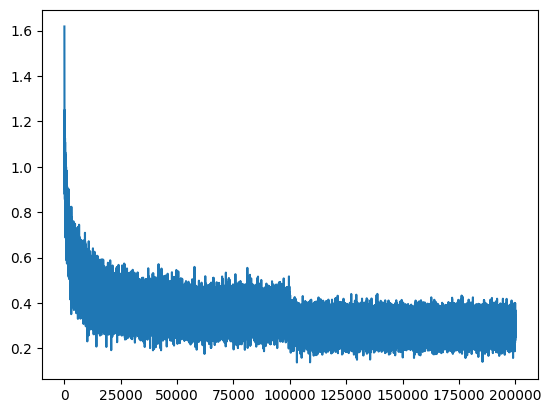

In [126]:
plt.plot(stepi, lossi)

In [127]:
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9758, grad_fn=<NllLossBackward0>)

In [128]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1881, grad_fn=<NllLossBackward0>)

We trained on few samples then added the whole dataset to improve learning rate. tested a variety of learning rates and graphed them to find the ideal learning rate. can move on to decay learning rate after a certain point. then realize that data is probably overfitting due to small data set and set hyperparameters for activation. thereforewe split the data into train val and test. use training data on the optimized lr and test the loss on val set. we increase the activation tensor sizes and test the val loss against the training loss. since val loss is ~= to training loss the data is most likely underfitting due to the hyperparameters so we increase the batch size to decrease noise. We play with lr and batch size to decrease the loss while the issue is most likely the fact that we are trying to cram so much into 2 dimentions

Then we increase the dimentional embeddings from 2 to 10 and plot log loss to improve plot. Tune hyperparameters until you are satisfied with dev performance and then test it on test performance once for the final accuracy

!!!Improved Andrej's val accuracy

In [129]:
emb = C[Xte] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1896, grad_fn=<NllLossBackward0>)